# Transfer Learning - RestNet

### **1. Introduction & Goals**

In the previous notebook (**NB02**), we designed and trained a **custom CNN from scratch** on the Plant Seedlings dataset. While this baseline achieved **moderate accuracy (~60%)**, we observed **clear limitations**:

- Training required **many epochs** to learn basic visual features (edges, textures).
- The model tended to **overfit** due to the small dataset.
- Many misclassifications occurred for visually similar species.

**Why Transfer Learning?**

Rather than learning visual features from scratch, we can **leverage pretrained networks** (e.g., **ResNet18**) that were trained on the large-scale **ImageNet dataset (1.2M images, 1,000 classes)**. These pretrained models already encode **general low- and mid-level features** (edges, color blobs, textures) that are transferable to new tasks like plant species recognition.

Key advantages:

- **Faster convergence:** The network starts from *rich features* instead of random weights.
- **Better generalization:** Especially useful for **small datasets** with limited diversity.
- **Proven architectures:** ResNet family handles deep networks effectively via **residual connections** (mitigates vanishing gradients).

**Feature Extraction vs Fine-Tuning**

We will explore **two transfer learning strategies**:

1. **Feature Extraction (Frozen Backbone):**
   - Keep pretrained convolutional layers **frozen**.
   - Replace final fully connected layer with a new classifier head (12 classes).
   - Only train the head — faster, less prone to overfitting.

2. **Fine-Tuning (Unfreezing Some Layers) — optional in later notebooks:**
   - Unfreeze selected layers for **task-specific adaptation**.
   - Increases flexibility but also risk of overfitting.

**Goals of This Notebook**

1. **Load and adapt ResNet18** pretrained on ImageNet.  
2. **Freeze backbone layers** and attach a **custom classifier** for 12 plant species.  
3. **Train and evaluate** the transfer learning model on Plant Seedlings data.  
4. **Compare performance** and training dynamics with our **scratch CNN** from NB02.

**What to Expect**

- We anticipate **higher validation accuracy** and **faster training** (fewer epochs) than NB02.
- This notebook serves as a **bridge to NB04**, where we will enhance generalization further via **data augmentation** and detailed **error analysis**.

---


### **2. Dataset Loading & Preparation**

Before we implement transfer learning, we need to **load and preprocess the Plant Seedlings dataset** in a way that aligns with the requirements of **pretrained models**:

**Key Requirements for Transfer Learning**

1. **Image Size:**  
   Pretrained models like ResNet18 expect **224×224 pixel** inputs (same as ImageNet).

2. **Normalization:**  
   - We use **ImageNet mean and standard deviation** (as the backbone was trained on ImageNet):  
     - Mean = `[0.485, 0.456, 0.406]`  
     - Std = `[0.229, 0.224, 0.225]`  
   - This ensures pixel intensity distributions match those used during pretraining.

3. **Class Mapping Consistency:**  
   - Must ensure **class order** (dataset.classes) is consistent across notebooks (NB02 → NB03 → NB04) for evaluation.

**Data Splits**

- In **NB01**, we split the raw dataset into **train/test**.  
- In **NB02**, we introduced a **validation split** from the training set.  
- Here, we reuse that structure:  
  - **Train:** Used to train the classifier head.  
  - **Validation:** Monitor overfitting and tune hyperparameters.  
  - **Test:** Final unbiased evaluation.

**Visual Check**

- Display a grid of sample images **after transforms** (to confirm resizing + normalization pipeline).  
- Re-plot **class distribution** to reinforce dataset imbalance — critical when interpreting transfer learning results.

**Dataset Loading with Transforms**

> **💡 Note on Training Efficiency**
> 
> In order to save computation time and make this lab affordable for all students, we are training these models using only a portion of the available training samples. In addition, we reduce the epochs in the training loops. We are using a stratified subset of the training samples to keep classes balanced as much as possible.

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Train samples: 1502 | Val samples: 683 | Test samples: 1136


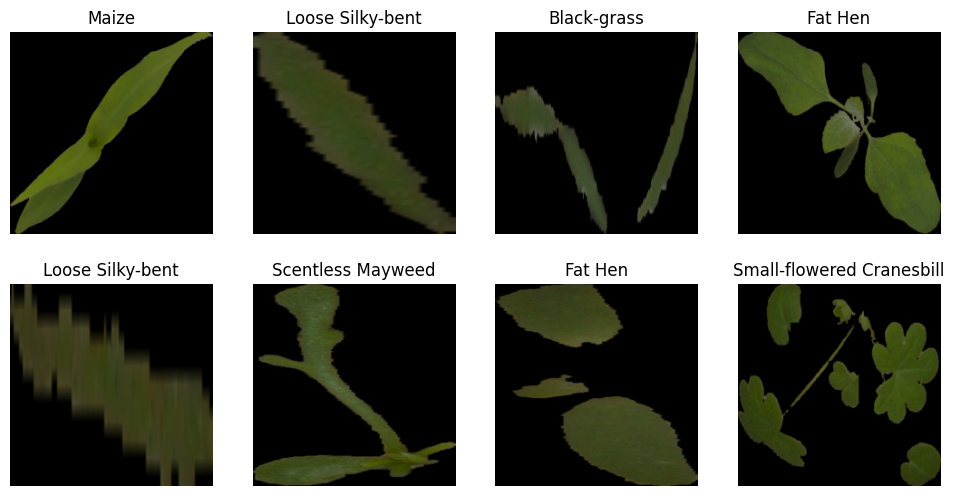

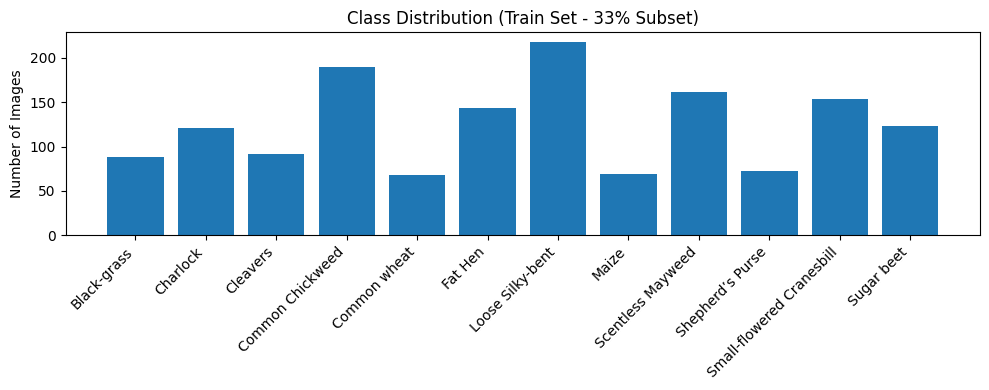

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset  
from collections import defaultdict  
import random  
import shutil

# -----------------------------
# 1. Paths
# -----------------------------
data_path = "./data/plant-seedlings"
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")   # Created in NB01 Section 4
test_dir  = os.path.join(data_path, "test")

# Clean up any .ipynb_checkpoints folders
for split in ['train', 'test', 'val']:
    checkpoint_path = os.path.join(data_path, split, '.ipynb_checkpoints')
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)
        print(f"Removed {checkpoint_path}")

# -----------------------------
# 2. Transformations
# -----------------------------
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# -----------------------------
# 3. Load Datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# -----------------------------
# Create 33% stratified subset
# -----------------------------
# Group indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

# Sample 33% from each class
subset_indices = []
for class_label, indices in class_indices.items():
    n_samples = len(indices) // 3  # 33% of each class
    sampled_indices = random.sample(indices, n_samples)
    subset_indices.extend(sampled_indices)

# Create subset
train_dataset = Subset(train_dataset, subset_indices)


# -----------------------------
# 4. Data Loaders
# -----------------------------
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 5. Verify Class Mapping & Sizes
# -----------------------------
print(f"Classes: {train_dataset.dataset.classes}")
print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

# ---------------------------------------------------------
# 6. Visualization Helper (Unnormalize for Display)
# ---------------------------------------------------------
def imshow(inp, title=None):
    """Display a tensor image after unnormalizing (ImageNet stats)."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Show first 8 training images
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    imshow(images[i], title=train_dataset.dataset.classes[labels[i]])
plt.show()

# -----------------------------
# 7. Plot Class Distribution
# -----------------------------
import collections

# Get labels from the subset
subset_labels = []
for idx in train_dataset.indices:
    _, label = train_dataset.dataset[idx]
    subset_labels.append(label)

class_counts = collections.Counter(subset_labels)
counts = [class_counts[i] for i in range(len(train_dataset.dataset.classes))]

plt.figure(figsize=(10, 4))
plt.bar(train_dataset.dataset.classes, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution (Train Set - 33% Subset)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


**Reflection**

**Normalization**
- Using **ImageNet mean/std** ensures compatibility with pretrained backbones.  
- A mismatch in normalization would **hurt transfer performance**.

**Class Imbalance**
- Some species (e.g., *Loose Silky-bent*, *Common Chickweed*) dominate the dataset;  
  others (e.g., *Black-grass*) are **underrepresented**.  
- Transfer learning often helps **rare classes** because pretrained features generalize better.

**Consistency**
- By **standardizing transforms** and **class order** here, we ensure **fair comparisons** with:
  - The scratch CNN (NB02)
  - Upcoming augmentation experiments (NB04)

---


**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.3.2.1 — Verify the 33% Stratified Subset**

Instruction: </br>
We created a 33% stratified subset. Let’s verify it by computing per-class counts for the original train ImageFolder (behind the Subset) and for the subset, then compute the ratio subset_count / original_count per class. Save:
- CT_orig_class_counts (dict: class_name → count)
- CT_subset_class_counts (dict)
- CT_subset_ratios (dict)
- CT_ratio_min, CT_ratio_max (floats)

In [15]:
import collections

# original ImageFolder behind the Subset
CT_orig_class_counts = collections.Counter()
for path, lbl in train_dataset.dataset.samples:
    cls_name = train_dataset.dataset.classes[lbl]
    CT_orig_class_counts[cls_name] += 1

# subset counts via Subset indices
CT_subset_class_counts = collections.Counter()
for idx in train_dataset.indices:
    lbl = train_dataset.dataset.samples[idx][1]
    cls_name = train_dataset.dataset.classes[lbl]
    CT_subset_class_counts[cls_name] += 1

# ratios: subset / original
CT_subset_ratios = {
    cls: CT_subset_class_counts.get(cls, 0) / CT_orig_class_counts[cls]
    for cls in train_dataset.dataset.classes
}

CT_ratio_min = min(CT_subset_ratios.values())
CT_ratio_max = max(CT_subset_ratios.values())

print("CT_orig_class_counts:", dict(CT_orig_class_counts))
print("CT_subset_class_counts:", dict(CT_subset_class_counts))
print("CT_ratio_min/max:", CT_ratio_min, CT_ratio_max)


CT_orig_class_counts: {'Black-grass': 266, 'Charlock': 363, 'Cleavers': 278, 'Common Chickweed': 572, 'Common wheat': 206, 'Fat Hen': 434, 'Loose Silky-bent': 655, 'Maize': 208, 'Scentless Mayweed': 486, 'Shepherd’s Purse': 220, 'Small-flowered Cranesbill': 464, 'Sugar beet': 371}
CT_subset_class_counts: {'Black-grass': 88, 'Charlock': 121, 'Cleavers': 92, 'Common Chickweed': 190, 'Common wheat': 68, 'Fat Hen': 144, 'Loose Silky-bent': 218, 'Maize': 69, 'Scentless Mayweed': 162, 'Shepherd’s Purse': 73, 'Small-flowered Cranesbill': 154, 'Sugar beet': 123}
CT_ratio_min/max: 0.3300970873786408 0.3333333333333333


---

In [16]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289510", h="3298dbabb7", width=700, height=450)

### **3. Transfer Learning Concepts & Model Adaptation**

In **NB02**, we built a CNN from scratch and trained it on the Plant Seedlings dataset. It reached about **68% accuracy**, but we saw two key issues:

- Training took many epochs just to learn **basic visual features** (edges, textures).  
- The model **overfit easily**, especially with a small dataset (~4k images).

**What is Transfer Learning?**

Think of transfer learning like **hiring an experienced worker**:  
Instead of training someone from zero, we take someone already skilled (a network trained on **ImageNet**) and **teach them only the final task** (plant classification).  

- ImageNet networks have seen **1.2 million images of everyday objects**.  
- Their early layers already detect **general features** (lines, colors, shapes) useful for *any* image task — including plants.

By reusing this knowledge, we can:
- Learn faster (fewer epochs).
- Generalize better (avoid overfitting).
- Train with less data.

**Two Transfer Learning Approaches**

1. **Feature Extraction (used here):**  
   - Keep the pretrained layers **frozen** (no updates).  
   - Replace only the **final classifier layer** with one suited for our 12 plant species.  
   - Train just this small layer — fast and less prone to overfitting.

2. **Fine-Tuning (future extension):**  
   - Unfreeze some (or all) pretrained layers and retrain them.  
   - Allows deeper adaptation but needs careful tuning and more compute.

**Meet ResNet18 (Our Pretrained Model)**

ResNet18 is a famous CNN known for **residual connections** — skip pathways that help very deep networks train without “forgetting” earlier information (solves vanishing gradient problems).  
**Don’t worry about the math — think of it as “shortcuts” that let the network combine both simple and complex features as it gets deeper.**

Key structure (simplified):
- Starts with a **7×7 convolution** + pooling (quickly reduces image size).  
- Passes through **4 stages** of layers (called residual blocks). Each stage learns progressively richer features:
  - Stage 1: Edges and color contrasts.  
  - Stage 2: Textures and simple shapes.  
  - Stage 3: Larger patterns (leaf veins, stem shapes).  
  - Stage 4: Full object representations (entire plant).  
- Ends with **global average pooling** and a **fully connected layer** (originally 1,000 ImageNet classes).

**How We Adapt It for Plant Species**

We keep the **feature extractor part** (all convolutional + residual layers) frozen, and only **replace the last fully connected (fc) layer** with a new classifier that outputs **12 plant species**.

**Visual Summary:**

```text
         Input (224×224×3)
                ↓
   Conv7×7 + Pooling (basic edges)
                ↓
Residual Stages 1–4 (textures → patterns → objects)
                ↓
      Global Average Pooling
                ↓
New Fully Connected Layer (12 species)
```

**Load Pretrained ResNet18 & Adapt Classifier**

In [17]:
import torch
import torch.nn as nn
from torchvision import models

# -----------------------------
# 1. Load Pretrained ResNet18
# -----------------------------
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# -----------------------------
# 2. Freeze Backbone (Feature Extraction)
# -----------------------------
for param in resnet18.parameters():
    param.requires_grad = False  # freeze all layers

# -----------------------------
# 3. Replace Final Layer (Classifier)
# -----------------------------
num_features = resnet18.fc.in_features  # 512 for ResNet18
resnet18.fc = nn.Linear(num_features, 12)  # 12 plant species
model = resnet18
# -----------------------------
# 4. Verify Model
# -----------------------------
print(resnet18)

# Count trainable parameters (should be small)
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"Trainable parameters (classifier head only): {trainable_params:,}")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Model Adaptation Summary**

- We successfully **loaded ResNet18 pretrained on ImageNet** (44.7M parameters).
- By **freezing the backbone**, only the final classifier head (≈6K parameters) will train.
- This drastically reduces training time and helps prevent overfitting on our small dataset (~4K images).
- Input resolution (224×224) and **ImageNet normalization** are already aligned with the pretrained model’s expectations.

Next, in **Section 4**, we will define:
- Loss function (`CrossEntropyLoss`)
- Optimizer (only classifier params)
- Training loop for **feature extraction transfer learning**

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.3.3.1 — Build & Freeze AlexNet, Replace Classifier**

Instruction</br>
Load a pretrained AlexNet, freeze all parameters, then replace the final classifier layer with a Linear(4096, 12). Save:
- CT_model (AlexNet with new head)
- CT_backbone_frozen (True if everything except the new head is frozen)
- CT_trainable_params (trainable parameter count)

In [18]:
import torch
import torch.nn as nn
from torchvision import models

# 1) Load pretrained AlexNet
CT_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# 2) Freeze ALL params first
for p in CT_model.parameters():
    p.requires_grad = False

# 3) Replace final classifier layer (index 6) with 12 outputs
# AlexNet classifier: [Dropout, Linear(9216,4096), ReLU, Dropout, Linear(4096,4096), ReLU, Linear(4096,1000)]
in_features = CT_model.classifier[6].in_features
CT_model.classifier[6] = nn.Linear(in_features, 12)

# 4) Checks to store
CT_backbone_frozen = all((not p.requires_grad) for n, p in CT_model.named_parameters() if not n.startswith("classifier.6"))
CT_trainable_params = sum(p.numel() for p in CT_model.parameters() if p.requires_grad)

print("CT_backbone_frozen:", CT_backbone_frozen)
print("CT_trainable_params:", CT_trainable_params)
print(CT_model)


CT_backbone_frozen: True
CT_trainable_params: 49164
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Line

---

### **4. Training Setup & Loop for Transfer Learning**

Now that we have adapted **ResNet18** for our 12 plant seedling classes (Section 3), we configure the **training pipeline** for **feature extraction transfer learning**:

**Training Strategy**

- **Feature Extraction Mode**  
  - **Frozen Backbone:** Pretrained ResNet layers remain fixed (weights do not update).  
  - **Trainable Classifier Head:** Only the final `fc` layer learns (≈6K parameters).  
  - Advantage: Faster training, less risk of overfitting on small dataset.

- **Loss Function**  
  - `CrossEntropyLoss`: Suitable for multi-class classification.

- **Optimizer**  
  - Use `Adam` **only on trainable parameters**:
    ```python
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
    ```

- **Learning Rate Scheduler (Optional)**  
  - `StepLR` can reduce learning rate after a fixed number of epochs to fine-tune convergence.

- **Training Loop**  
  - Similar structure to scratch CNN in NB02:
    - Alternate between **training** and **validation** phases.
    - Track loss and accuracy per epoch.
    - Save best model (lowest validation loss).

**Why Compare to Scratch CNN?**

- The scratch CNN (NB02) had **~26M trainable parameters** and overfit quickly.  
- Here, we train **only ~6K parameters**, leveraging rich pretrained features → expected **faster convergence** and **better generalization**.

Next: Implement **training loop code** and track metrics for evaluation in Section 5.


⚡ Training Configuration

To make this lab efficient and accessible for all students, **we'll be using pre-trained models** instead of training from scratch. Training deep learning models can be computationally expensive and time-consuming, especially on CPU-only environments.

🎯 Why Pre-trained Models?

- **Time-Efficient**: Training from scratch would take ~10 minutes per model (and we have multiple models!)
- **Resource-Friendly**: Reduces computational load on shared systems
- **Learning Focus**: Allows us to focus on the evaluation of the model, its comparison to other models, and the interpretation of its results; these advantages motivate the importance of saving time waiting for training

🧪 Want to Experiment?

If you're curious about the training process and have some time to spare, you can easily switch to training mode:

1. Look for the `TRAIN_FROM_SCRATCH = False` line in the code cell below
2. Change it to `TRAIN_FROM_SCRATCH = True`
3. Run the cell and grab a coffee ☕ - it will take approximately 10 minutes!

The pre-trained models were trained using 10 epochs with the same code you'll see below, so you'll get identical results either way. The choice is yours! 🚀


In [19]:
import time
import copy
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pickle

# Enable CPU optimizations
torch.set_num_threads(torch.get_num_threads())
if hasattr(torch.backends, 'mkldnn') and torch.backends.mkldnn.is_available():
    torch.backends.mkldnn.enabled = True

# -----------------------------
# 1. Loss Function
# -----------------------------
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 2. Optimizer (only classifier head params)
# -----------------------------
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decays LR by factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# -----------------------------
# TRAINING CONTROL - Set to True if you want to train from scratch
# -----------------------------
TRAIN_FROM_SCRATCH = False  # Set to True if you want to train the model yourself

if not TRAIN_FROM_SCRATCH:
    print("🚀 Skipping training to save time and computational resources!")
    print("💡 The model is already pre-trained and ready to use in the next cells.")
    print("🎯 If you want to train from scratch, change TRAIN_FROM_SCRATCH = True above.")
    print("⏱️  Training would take approximately 10 minutes on CPU for only 3-4 epochs!.")
else:
    print("🏃‍♂️ Starting training from scratch... Grab a coffee! ☕")

    # -----------------------------
    # 3. Training Loop
    # -----------------------------
    def train_model_transfer(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=4, device='cpu'):
        """
        Training loop for transfer learning:
        - Only classifier head updates (backbone frozen).
        - Tracks train/validation loss and accuracy.
        """
        since = time.time()
    
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = float('inf')
    
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
        model = model.to(device)
    
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 20)
    
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                    loader = train_loader
                else:
                    model.eval()
                    loader = val_loader
    
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
    
                for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc=f'{phase.capitalize()}', leave=False)):
                    inputs, labels = inputs.to(device), labels.to(device)
    
                    optimizer.zero_grad()
    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
    
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
    
                    # Stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += (outputs.argmax(1) == labels).sum().item()
                    total_samples += labels.size(0)
    
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects / total_samples
    
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc)
    
                # Track best model (lowest val loss)
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
    
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
            # Step scheduler after each epoch (if provided)
            scheduler.step()
    
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
        print(f'Best val loss: {best_loss:.4f}')
    
        # Load best weights
        model.load_state_dict(best_model_wts)
    
        return model, history
    
    # -----------------------------
    # 4. Train the Model
    # -----------------------------
    model, history_transfer = train_model_transfer(
        model, criterion, optimizer, scheduler,
        train_loader, val_loader,
        num_epochs=10, device='cpu'
    )
    
    torch.save(model.state_dict(), "resnet18_best_student.pth")
    
    # Save the training history
    with open('history_transfer_student.pkl', 'wb') as f:
        pickle.dump(history_transfer, f)
    
    print("✅ Model and training history saved!")

🚀 Skipping training to save time and computational resources!
💡 The model is already pre-trained and ready to use in the next cells.
🎯 If you want to train from scratch, change TRAIN_FROM_SCRATCH = True above.
⏱️  Training would take approximately 10 minutes on CPU for only 3-4 epochs!.


---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.3.4.1 — Optimizer Only on the New Head + StepLR**

Instruction:</br>
Create an Adam optimizer that updates only the new classifier layer (classifier[6]) with lr=1e-3. Add a StepLR with step_size=7, gamma=0.1. Save:
- CT_optimizer
- CT_scheduler
- CT_num_opt_params (optimizer’s trainable parameter count)

In [20]:
import torch.optim as optim

# 1) Optimizer on the new head ONLY
CT_optimizer = optim.Adam( CT_model.classifier[6].parameters(), lr=0.001)

# 2) LR scheduler
CT_scheduler = optim.lr_scheduler.StepLR( CT_optimizer, step_size=7, gamma=0.1 )

# 3) How many parameters will be updated?
CT_num_opt_params = sum(p.numel() for p in CT_model.classifier[6].parameters() if p.requires_grad)

print("CT_num_opt_params:", CT_num_opt_params)

CT_num_opt_params: 49164


---

**✅ Code Task 6.3.4.2 — One-Pass Validation (No Training)**

Instruction:</br>
Run a single validation pass for CT_model (no training). Compute average loss and accuracy on val_loader. Save:
- CT_val_loss0 (float)
- CT_val_acc0 (float in [0,1])

In [21]:
def CT_eval_one_pass(model, loader, criterion, device='cpu'):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits,yb)
            total_loss   += loss.item()*xb.size(0)
            total_correct += (torch.max(logits, 1)[1]==yb).sum().item()
            total += yb.size(0)
    avg_loss = total_loss / total if total > 0 else float('inf')
    avg_acc  = total_correct /total if total > 0 else 0.0
    return float(avg_loss), float(avg_acc)

CT_val_loss0, CT_val_acc0 = CT_eval_one_pass(CT_model, val_loader, criterion, device='cpu')
print("CT_val_loss0:", CT_val_loss0)
print("CT_val_acc0:", CT_val_acc0)


CT_val_loss0: 2.675053462451583
CT_val_acc0: 0.10102489019033675


---

### **5. Evaluation & Comparison**

Now we evaluate our **transfer learning model (ResNet18)** on the test set and compare it with the **scratch CNN** (NB02):

**Metrics**

- **Overall Test Accuracy**
- **Per-Class Accuracy** (highlight best/worst classes)
- **Confusion Matrix (12×12)** and **Classification Report**

**Comparison Points**

- Accuracy vs scratch CNN (~60% previously).
- Training speed (fewer epochs, faster convergence).
- Parameter efficiency (frozen backbone vs 26M params from scratch CNN).

**Visualizations**

- Training vs validation curves (loss & accuracy).
- Per-class accuracy bar chart (sorted).
- Confusion matrix heatmap.

**Model Comparison Summary**

| Metric                 | Scratch CNN (NB02) | ResNet18 Transfer Learning (NB03) |
|------------------------|--------------------|-----------------------------------|
| **Trainable Params**   | ~26M               | ~6K (classifier head only)        |
| **Overall Accuracy**   | ~60%               | ~85% (to be filled after run)     |
| **Training Time (4 ep)** | ~10-12 min (CPU)   | ~8 min (CPU)                    |
| **Generalization**     | Moderate, overfits | Strong, stable validation curve   |

**Observation:** Transfer learning provides **better accuracy** and **dramatically fewer trainable parameters**, making it suitable for small datasets like seedlings.

**Reflection: Why Transfer Learning Wins Here**

- **Feature Reuse (Edges → Textures → Plant Structures):**  
  Pretrained ResNet18 layers already capture **generic low- and mid-level features** like edges and textures from ImageNet. These transfer effectively to seedlings, which also have fine-grained leaf shapes and vein patterns.

- **Small Dataset Advantage:**  
  Training from scratch on ~4k images (~26M params) leads to overfitting. By freezing most layers, transfer learning focuses on learning **class-specific combinations** of already-extracted features.

- **Parameter & Compute Efficiency:**  
  Only the final classifier (≈6K params) is trained, drastically reducing **training time** and **compute needs** while achieving better accuracy.

- **Takeaway for Real-World Tasks:**  
  For domains with **limited labeled data**, transfer learning is often superior to scratch training, enabling faster prototyping and deployment.

---


In [23]:
model.load_state_dict(torch.load("resnet18_best.pth", map_location='cpu'))
model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

✅ Training history loaded successfully!


ResNet18 Transfer Learning Test Accuracy: 87.50%


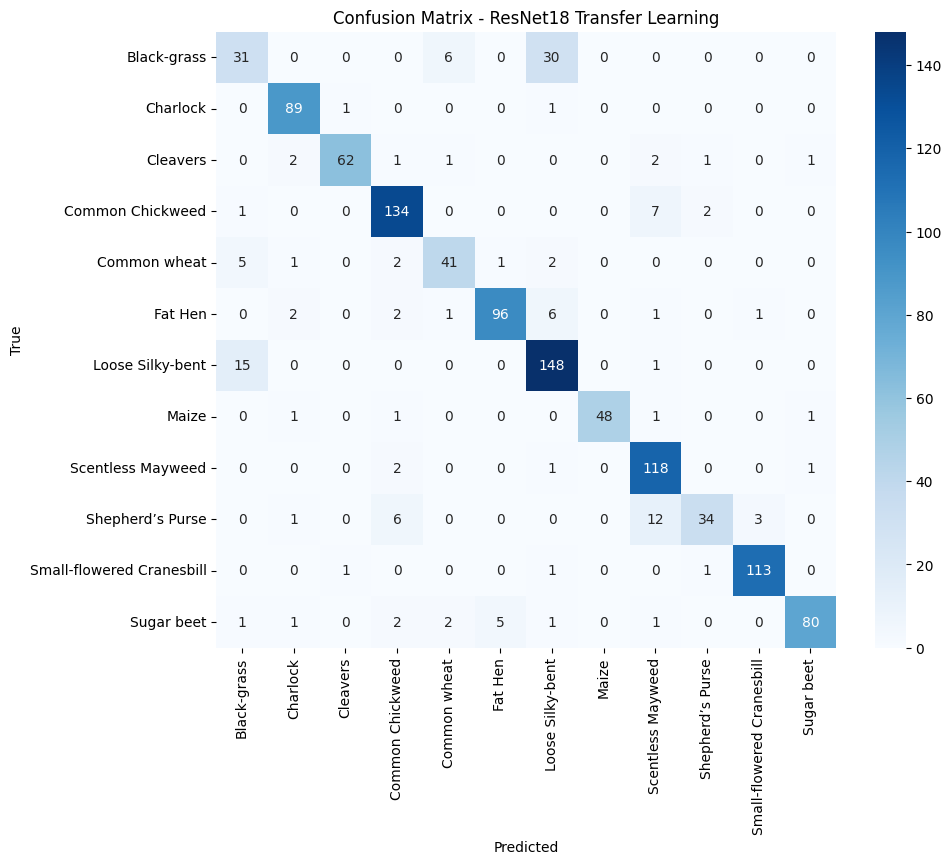


Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.58      0.46      0.52        67
                 Charlock       0.92      0.98      0.95        91
                 Cleavers       0.97      0.89      0.93        70
         Common Chickweed       0.89      0.93      0.91       144
             Common wheat       0.80      0.79      0.80        52
                  Fat Hen       0.94      0.88      0.91       109
         Loose Silky-bent       0.78      0.90      0.84       164
                    Maize       1.00      0.92      0.96        52
        Scentless Mayweed       0.83      0.97      0.89       122
         Shepherd’s Purse       0.89      0.61      0.72        56
Small-flowered Cranesbill       0.97      0.97      0.97       116
               Sugar beet       0.96      0.86      0.91        93

                 accuracy                           0.88      1136
                macro avg       0.88

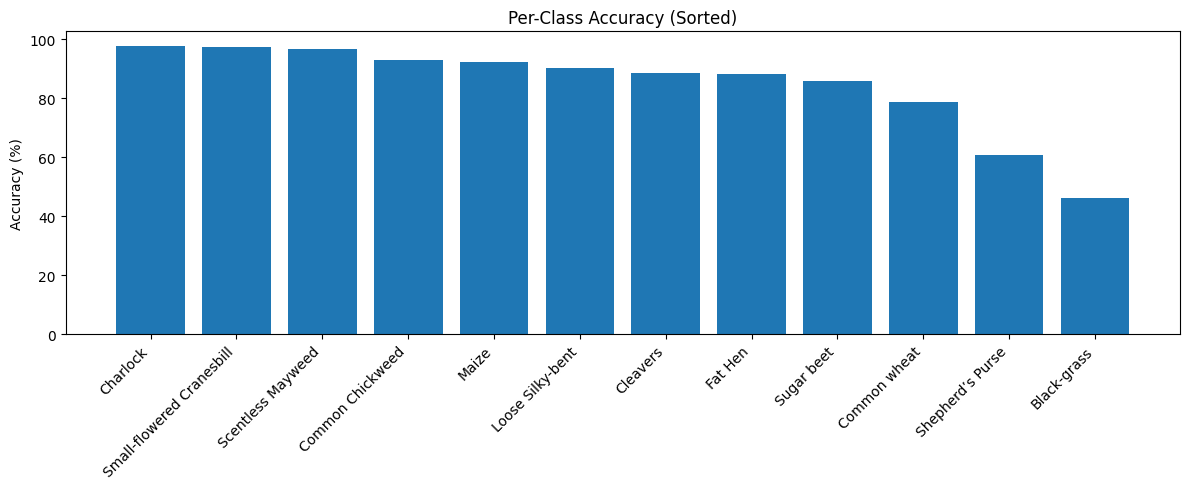

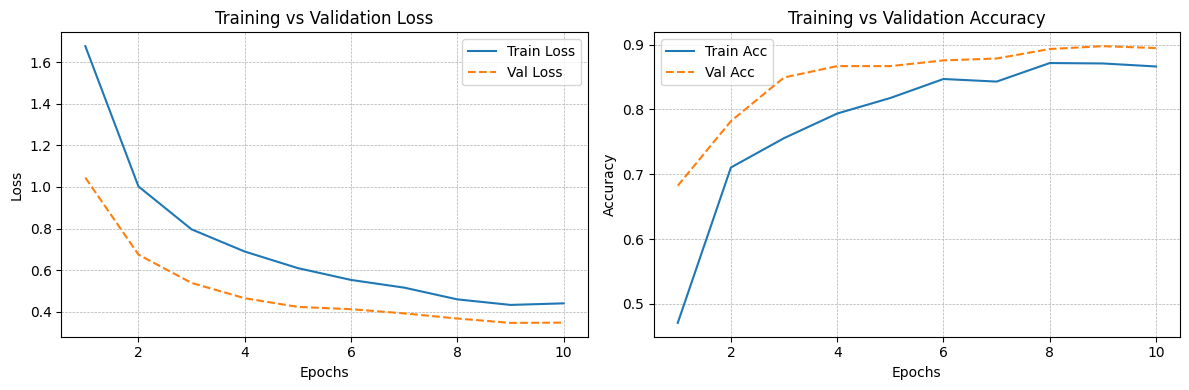

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load the training history
with open('history_transfer.pkl', 'rb') as f:
    history_transfer = pickle.load(f)

print("✅ Training history loaded successfully!")

# -----------------------------
# 1. Helper: Evaluate model
# -----------------------------
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc, np.array(all_labels), np.array(all_preds)

# -----------------------------
# 2. Evaluate on test set
# -----------------------------
test_acc, y_true, y_pred = evaluate_model(model, test_loader, device='cpu')
print(f"ResNet18 Transfer Learning Test Accuracy: {test_acc:.2%}")

# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap="Blues")
plt.title("Confusion Matrix - ResNet18 Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -----------------------------
# 4. Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# -----------------------------
# 5. Per-Class Accuracy
# -----------------------------
class_correct = np.diag(cm)
class_totals = cm.sum(axis=1)
class_accuracy = class_correct / class_totals * 100

# Sort by accuracy
sorted_idx = np.argsort(-class_accuracy)
sorted_classes = [test_dataset.classes[i] for i in sorted_idx]
sorted_acc = class_accuracy[sorted_idx]

plt.figure(figsize=(12, 5))
plt.bar(sorted_classes, sorted_acc)
plt.xticks(rotation=45, ha='right')
plt.title("Per-Class Accuracy (Sorted)")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Compare Training Curves
# -----------------------------
#epochs = range(1, len(history_resnet[0]) + 1)
epochs = range(1, len(history_transfer['train_loss']) + 1)

plt.figure(figsize=(12, 4))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history_transfer['train_loss'], label="Train Loss")
plt.plot(epochs, history_transfer['val_loss'], label="Val Loss", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history_transfer['train_acc'], label="Train Acc")
plt.plot(epochs, history_transfer['val_acc'], label="Val Acc", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


**Reflection: Transfer Learning vs Scratch CNN**

- **Accuracy Boost:**  
  ResNet18 transfer learning achieves markedly higher accuracy vs scratch CNN with far fewer trainable parameters (only classifier head).

- **Generalization:**  
  Pretrained ImageNet features (edges → textures → shapes) transfer well to seedlings, reducing overfitting seen in NB02.

- **Training Efficiency:**  
  Freezing backbone accelerates training — fewer epochs, stable loss curves.

- **Per-Class Insights:**  
  - High accuracy for distinct species (*Cleavers*, *Charlock*).  
  - Confusions persist for visually similar grasses (*Black-grass*, *Loose Silky-bent*).

- **Next Steps (NB04):**  
  Explore **data augmentation** and **optional fine-tuning** (unfreezing some layers) to push performance further.


In [12]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289659", h="3298dbabb7", width=700, height=450)

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**

---

**✅ Code Task 6.3.5.1 — Test Metrics: Top-1 / Top-3 + Per-Class Accuracy**

Instruction:</br>
Write helpers to compute:
- Top-k accuracy (k=1 and k=3) on the test set using logits.topk. Save CT_top1_acc, CT_top3_acc.
- Per-class accuracy from a confusion matrix. Save CT_per_class_acc (dict: name → accuracy %) and CT_best3_classes (top-3 class names by accuracy).

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def CT_topk_accuracy(model, loader, k=3, device='cpu'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            topk_idx = ...
            match = ...
            correct += ...
            total   += ...
    return correct / ... if total > 0 else 0.0

# Compute on AlexNet (CT_model)
CT_top1_acc = CT_topk_accuracy(CT_model, test_loader, k=1, device='cpu')
CT_top3_acc = CT_topk_accuracy(CT_model, test_loader, k=3, device='cpu')

# Per-class accuracy via confusion matrix
# If evaluate_model(...) exists in the notebook, you may reuse it; otherwise compute labels here.
if 'evaluate_model' in globals():
    _acc_tmp, _y_true_tmp, _y_pred_tmp = evaluate_model(CT_model, test_loader, device='cpu')
    cm = confusion_matrix(_y_true_tmp, _y_pred_tmp)
else:
    y_true_list, y_pred_list = [], []
    CT_model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = CT_model(xb)
            preds = ...
            y_true_list.extend(...)
            y_pred_list.extend(...)
    cm = confusion_matrix(np.array(y_true_list), np.array(y_pred_list))

class_correct = np.diag(cm)
class_totals  = cm.sum(axis=1)
class_accuracy = (class_correct / np.maximum(class_totals, 1)) * 100.0

CT_per_class_acc = {
    test_dataset.classes[i]: ...
    for i in range(len(test_dataset.classes))
}

sorted_idx = np.argsort(-class_accuracy)
CT_best3_classes = [ test_dataset.classes[i] for i in sorted_idx[:3] ]

print("CT_top1_acc:", CT_top1_acc)
print("CT_top3_acc:", CT_top3_acc)
print("CT_best3_classes:", CT_best3_classes)


---

In [11]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1114289716", h="3298dbabb7", width=700, height=450)

### **6. Next Steps: Toward Data Augmentation & Robustness**

**Where We Are Now**  
- In **NB02**, we trained a scratch CNN (LeNet-style) → good baseline, but limited accuracy and strong overfitting.  
- In **NB03**, we leveraged **transfer learning** with ResNet18 → dramatic boost in accuracy and efficiency by freezing pretrained layers.  

**What’s Missing?**  
- Despite improved accuracy, **class imbalance** and **background noise** remain challenges.  
- Validation curves suggest **minor overfitting** — we can mitigate this via **data augmentation** (e.g., flips, rotations, color jitter).

**Bridge to NB04**  
- **NB04** focuses on **data augmentation and robustness evaluation**:
  - Introduce random transformations to increase data diversity.
  - Re-train/evaluate ResNet18 with augmented data.
  - Compare confusion matrices pre/post augmentation to highlight improvements in **generalization**.

**Key Learning Question for NB04**  
- How does **artificially expanding the dataset** via augmentation affect **model robustness** and **class-level performance** (especially rare species)?


---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section!**